In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
def read_points(dataset_name, label_col_number):
    points = []
    labels = []
    with open (dataset_name, 'r') as fin:
        csvReader = csv.reader(fin, delimiter=',')
        for row in csvReader:
            if csvReader.line_num != 1:
                float_row = []
                for i in range(0, len(row)):
                    if i != label_col_number:
                        float_row.append(float(row[i]))
                points.append(float_row)
                labels.append(row[label_col_number])
    return points, labels

In [3]:
import itertools
import random

In [4]:
def p_k(labels, R, label):
    pk = 0
    for index in R:
        if labels[index] == label:
            pk += 1
    return pk * 1.0 / len(R)

In [5]:
def gini(labels, R, unique_labels):
    s = 0
    for label in unique_labels:
        s+= p_k(labels, R, label) * (1 - p_k(labels, R, label))
    return s

In [6]:
def split_vertex(labels, points, vertex_points, unique_labels, N, max_depth):
    label0 = labels[vertex_points[0]]
    eq_labels = True
    for index in vertex_points:
        if labels[index] != label0:
            eq_labels = False
            break;
    if eq_labels:
        return 1, label0
    
    lbls = {}
    count, lbl = 0, '' 
    for index in vertex_points:
        label = labels[index]
        lbls[label] = lbls.get(label, 0) + 1
        if lbls[label] >= count:
            count, lbl = lbls[label], label    
    if max_depth == 1:
        return count * 1.0 / len(vertex_points), lbl
    I = gini(labels, vertex_points, unique_labels)
    maxIG = 0
    for j in range(len(points[0])):
        feature_vals = [i[j] for i in points]
        max_val = np.array(feature_vals).max()
        min_val = np.array(feature_vals).min()
        for i in range(N + 1):
            value = min_val + i * 1.0 * (max_val - min_val) / N
            left = list(filter(lambda x: points[x][j] < value, vertex_points))
            right = list(set(vertex_points) - set(left))
            if left and right:
                Il = gini(labels, left, unique_labels)
                Ir = gini(labels, right, unique_labels)
                IG = I - len(left) * 1.0 / len(vertex_points) * Il - len(right) * 1.0 / len(vertex_points) * Ir
                if maxIG < IG:
                    maxIG = IG
                    maxL = left
                    maxR = right
                    maxJ = j
                    maxValue = value
    if maxIG == 0:
         return count * 1.0 / len(vertex_points), lbl 
    return count * 1.0 / len(vertex_points), lbl, maxJ, maxValue, split_vertex(labels, points, maxL, unique_labels, N, max_depth - 1), split_vertex(labels, points, maxR, unique_labels, N, max_depth - 1)

In [7]:
def build_tree(points, labels, unique_labels, N, max_depth):
    indexes = [i for i in range(len(points))]
    return split_vertex(labels, points, indexes, unique_labels, N, max_depth)

In [8]:
def split(points, labels):
    test_validate_indexes = random.sample(range(len(points)), len(points) * 3 // 10)
    train_indexes = set([i for i in range(len(points))]) - set(test_validate_indexes)
    test_indexes = random.sample(test_validate_indexes, len(test_validate_indexes) // 2)
    validate_indexes = set(test_validate_indexes) - set(test_indexes)
    return [points[i] for i in train_indexes], [labels[i] for i in train_indexes], [points[i] for i in validate_indexes], [labels[i] for i in validate_indexes], [points[i] for i in test_indexes], [labels[i] for i in test_indexes]

In [9]:
def get_label_from_tree(tree, point, max_depth):
    if len(tree) == 2 or max_depth == 1:
        return tree[0], tree[1]
    if point[tree[2]] < tree[3]:
        score, label = get_label_from_tree(tree[4], point, max_depth - 1)
        return score, label
    score, label = get_label_from_tree(tree[5], point, max_depth - 1)
    return score, label

In [10]:
def get_best_depth(tree, points, labels):
    max_cnt = -1
    max_depth = 0
    for depth in range(1, 11):
        cnt = 0
        for i in range(len(points)):
            if labels[i] == get_label_from_tree(tree, points[i], depth)[1]:
                cnt += 1
        if cnt > max_cnt:
            max_cnt = cnt
            max_depth = depth
    return max_depth
            

In [11]:
def roc(points, labels, true_label, scores, true_label_scores):
    x = [0]
    y = [0]
    for j in range(len(true_label_scores)):
        true_score = true_label_scores[j]
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        for i in range(len(scores)):
            if scores[i] >= true_score:
                if labels[i] == true_label:
                    tp += 1
                else:
                    fp += 1
            else:
                if labels[i] == true_label:
                    fn += 1
                else:
                    tn += 1
        if tp + fn != 0:
            y.append(tp * 1.0 / (tp + fn))
        else:
            y.append(0)
        if fp + tn != 0:
            x.append(fp * 1.0 / (fp + tn))
        else:
            x.append(0)
    return x, y    

In [12]:
def eval_test(dataset_name, label_col_number, true_label, N):
    points, labels = read_points(dataset_name, label_col_number)
    unique_labels = np.unique(np.array(labels)).tolist()
    train_points, train_labels, validate_points, validate_labels, test_points, test_labels = split(points, labels)
    tree = build_tree(train_points, train_labels, unique_labels, N, 10)
    depth = get_best_depth(tree, validate_points, validate_labels)
    print("Best depth = " + str(depth))
    scores = []
    for i in range(len(test_points)):
        point = test_points[i]
        score, label = get_label_from_tree(tree, point, depth)
        if label != true_label:
            score = 1 - score
        scores.append(score)  
    true_label_scores = list(scores)
    true_label_scores = sorted(set(true_label_scores), reverse=True)
    x, y = roc(test_points, test_labels, true_label, scores, true_label_scores)
    plt.plot(x, y)
    plt.show()

Best depth = 4


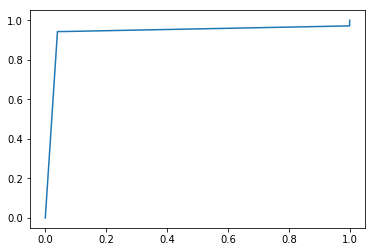

In [13]:
eval_test('datasets/cancer.csv', 0, 'M', 1000)

Best depth = 7


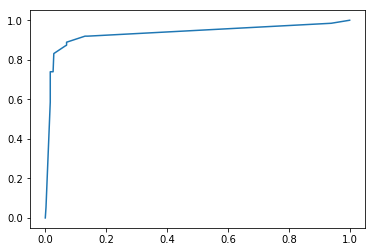

In [14]:
eval_test('datasets/spam.csv', 57, '1', 100)